In [1]:
from process_bigraph import ProcessTypes, Composite, register_types
from vivaCRM.crm_gsmm_golford import crm_goldford, get_crm_goldford_emitter, plot_crm_goldford_simulation
from CRM.crm_gsmm_goldford_utils import extract_yields, extract_byproducts, extract_uptake_rates, run_mcrm_from_extractions, plot_mcrm, build_crm_goldford_config, make_initial_state
from cobra.io import load_model
from process_bigraph.emitter import gather_emitter_results
import numpy as np

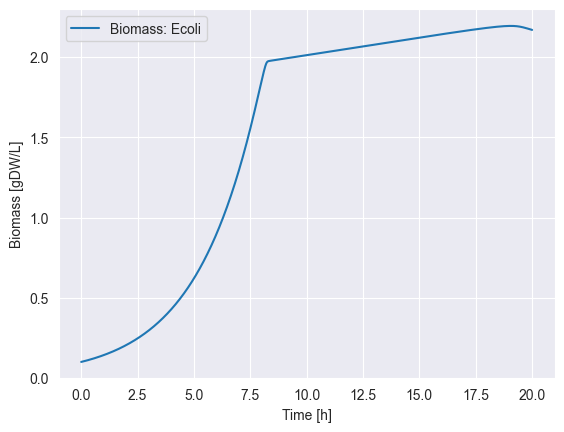

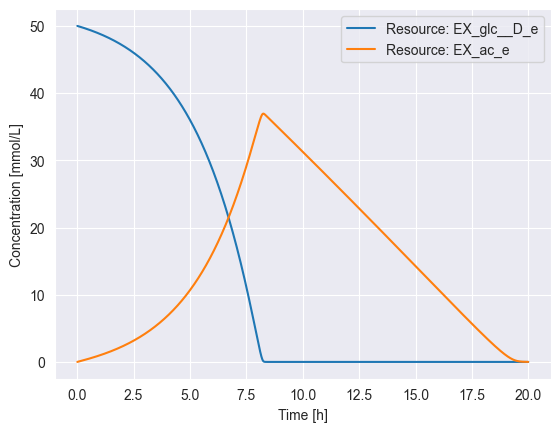

In [2]:
model = load_model("textbook")
resource_ids = ["EX_glc__D_e", "EX_ac_e"]  # choose resources to model

#Extract information from the gsmm file
extractions = {
    "Ecoli": {
        "yields": extract_yields(model, resource_ids, biomass_rxn_id="Biomass_Ecoli_core",
                                 uptake_cap=10.0, o2_lb=2.0, atpm_flux=1.0, use_pfba=False),
        "byproducts": extract_byproducts(model, resource_ids, biomass_rxn_id="Biomass_Ecoli_core",
                                         uptake_cap=10.0, o2_lb=2.0, atpm_flux=1.0, use_pfba=False),
        "uptakes": extract_uptake_rates(model, resource_ids, biomass_rxn_id="Biomass_Ecoli_core",
                                        uptake_cap=10.0, o2_lb=2.0, atpm_flux=1.0, use_pfba=False),
    }
}

# 2) Monod Km per resource
Km = {"EX_glc__D_e": 0.5, "EX_ac_e": 0.5}

# 3) Initial conditions (dicts)
n0 = {"Ecoli": 0.1}
R0 = {"EX_glc__D_e": 50.0, "EX_ac_e": 0.0}

# 4) Simulate
t, X, sp_order, res_order, params = run_mcrm_from_extractions(
    extractions, resource_ids, Km,
    initial_biomass_by_species=n0,
    initial_resources_by_id=R0,
    use_uptake_as_vmax=True,
    dilution=0.0,
    T=20.0, steps=1500,
)

# 5) Plot
plot_mcrm(t, X, sp_order, res_order)

# Vivarium implementation

In [5]:
model = load_model("textbook")
resource_ids = ["EX_glc__D_e", "EX_ac_e"]  # choose resources to model
extractions = {
    "Ecoli": {
        "yields": extract_yields(model, resource_ids, biomass_rxn_id="Biomass_Ecoli_core",
                                 uptake_cap=10.0, o2_lb=2.0, atpm_flux=1.0, use_pfba=False),
        "byproducts": extract_byproducts(model, resource_ids, biomass_rxn_id="Biomass_Ecoli_core",
                                         uptake_cap=10.0, o2_lb=2.0, atpm_flux=1.0, use_pfba=False),
        "uptakes": extract_uptake_rates(model, resource_ids, biomass_rxn_id="Biomass_Ecoli_core",
                                        uptake_cap=10.0, o2_lb=2.0, atpm_flux=1.0, use_pfba=False),
    }
}

# 2) Monod Km per resource
Km = {"EX_glc__D_e": 0.5, "EX_ac_e": 0.5}

# 2) build crm_goldford config
cfg = build_crm_goldford_config(extractions, resource_ids, Km,
                                maintenance_by_species={"Ecoli": 0.02},
                                dilution=0.0,
                                feed_by_resource={}, resource_loss_by_resource={})

# 3) initial state
state0 = make_initial_state(["Ecoli"], resource_ids,
                            n0_by_species={"Ecoli": 0.1},
                            R0_by_resource={"EX_glc__D_e": 50.0, "EX_ac_e": 0.0})

In [6]:
cfg

{'species_names': ['Ecoli'],
 'resource_names': ['EX_glc__D_e', 'EX_ac_e'],
 'yields': {'Ecoli': {'EX_glc__D_e': 0.036460709235373576,
   'EX_ac_e': 0.01857921060649978}},
 'resource_uptakes': {'Ecoli': {'EX_glc__D_e': 10.0,
   'EX_ac_e': 1.6836817047153696}},
 'maintenance': {'Ecoli': 0.02},
 'Km': {'EX_glc__D_e': 0.5, 'EX_ac_e': 0.5},
 'byproducts': {'Ecoli': {'EX_glc__D_e': {'EX_ac_e': 0.909657903252336},
   'EX_ac_e': {}}},
 'dilution': 0.0,
 'feed': {'EX_glc__D_e': 0.0, 'EX_ac_e': 0.0},
 'resource_loss': {'EX_glc__D_e': 0.0, 'EX_ac_e': 0.0}}

In [7]:
state0

{'species': {'Ecoli': 0.1},
 'concentrations': {'EX_glc__D_e': 50.0, 'EX_ac_e': 0.0},
 'strategies': {'Ecoli': {'EX_glc__D_e': 0.0, 'EX_ac_e': 0.0}}}

In [8]:
adaptive_spec = {
    "adaptive_crm": {
        "_type": "process",
        "address": "local:crm_goldford",
        "config": cfg,
        "inputs": {
            "species": ["species"],
            "concentrations": ["concentrations"],
            "strategies": ["strategies"],
        },
        "outputs": {
            "species_delta": ["species"],
            "concentrations_delta": ["concentrations"],
            "strategies_delta": ["strategies"],
        },
        "interval": 1.0,
    }
}

In [9]:
# Merge initial state
spec = {**adaptive_spec, **state0}

# Create emitter
state_keys = ["species", "concentrations", "strategies", "global_time"]
spec["emitter"] = get_crm_goldford_emitter(state_keys)

# Register process
core = ProcessTypes()
core = register_types(core)
core.register_process("crm_goldford", crm_goldford)  # Make sure your class is named this



In [10]:
# Create and run simulation
sim = Composite({
    "state": spec,
}, core=core)

sim.run(20)

In [11]:
results = gather_emitter_results(sim)[('emitter',)]

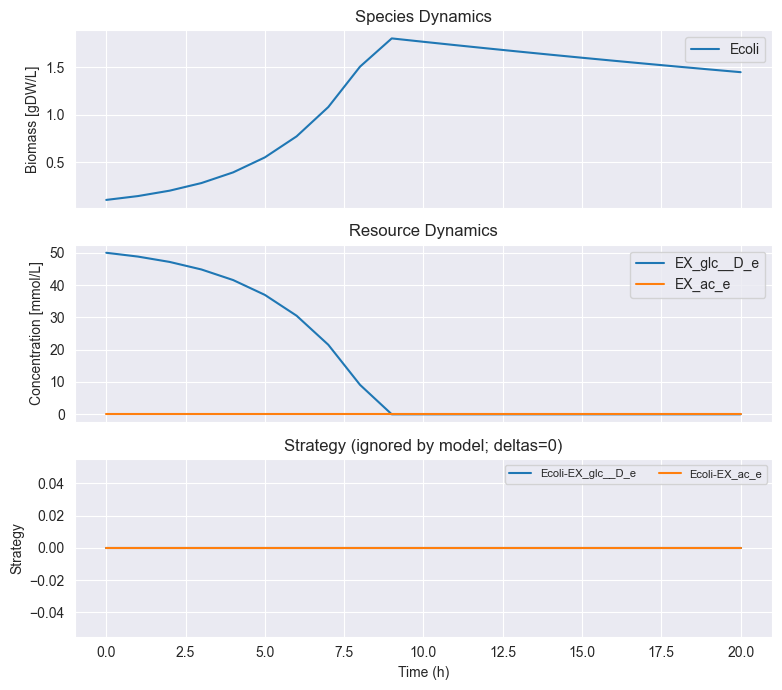

In [12]:
plot_crm_goldford_simulation(results)